# **Проект "Нейросеть для автодополнения текстов"**

## **1. Введение**

**Описание проекта:** заказчики (разработчики) соцсетевого приложения, где пользователи постят короткие тексты, хотят добавить возможность автодополнения текстов. Заказчики обратились за созданием соответствующей модели, которую можно запускать на мобильных устройствах. 

**Цель:** создать нейросеть, которая на основе начала фразы предсказывает её продолжение.

**План работы:**
1) загрузка и предобработка данных (очистка данных, создание датасета и токенизация) 
2) обучение модели (нейросети) LSTM и оценка её качества (ROUGE метрики)
3) подбор параметров генерации для предобученного трансформера DISTILGPT2 и оценка его качества (ROUGE метрики)
4) сравнение примеров предсказаний и общего качества (ROUGE метрик) двух моделей: LSTM и DISTILGPT2

**Имеющиеся данные:** датасет с твитами, находящийся по адресу https://code.s3.yandex.net/deep-learning/tweets.txt 

**Примечания:** согласно требованию заказчиков, для смартфонов есть значительные требования по оперативной памяти и скорости работы, так что важна легковесность модели. Поэтому не будет перегружать модели большим количеством слоёв, высокой размерностью скрытых состояний и т.д. 

In [1]:
# ========== ИМПОРТ БИБЛИОТЕК ==========

# импортируем необходимые библиотеки
import sys
import os

sys.path.append(os.path.join(os.getcwd(), 'src'))

import pandas as pd
import numpy as np
import re
import requests
import io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast
from transformers import AutoTokenizer, AutoModelForCausalLM  
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# импортируем функции и классы из папки src
from compare_model_predictions import compare_model_predictions
from compute_rouge_metrics import compute_rouge_metrics
from find_best_generation_params import find_best_generation_params 
from generate_with_gpt2 import generate_with_gpt2
from load_and_clean_data import load_and_clean_data
from LSTMLanguageModel import LSTMLanguageModel
from NextTokenDataset import NextTokenDataset
from plot_training_progress import plot_training_progress
from set_seed import set_seed
from show_generation_examples import show_generation_examples
from show_gpt2_predictions import show_gpt2_predictions
from train_model import train_model

d:\VS CODE 2\TEXT PROJECT 1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Используем gpu для ускорения вычислений:**

In [2]:
set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


**Создаём директорию models, куда сохраним модели:**

In [3]:
os.makedirs("models", exist_ok=True)

## **2. Предобработка данных**

### **2.1 Загрузка и очистка данных**

In [4]:
dataset_processed = load_and_clean_data()

Загрузка данных с URL: https://code.s3.yandex.net/deep-learning/tweets.txt
Успешно загружено 1600498 строк
Загружено твитов: 1600498
После очистки: 1592794


### **2.2 Создание датасета и токенизация**

In [5]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# параметры
CONTEXT_LEN = 8
BATCH_SIZE = 512 if torch.cuda.is_available() else 256

# создаем датасет
full_dataset = NextTokenDataset(dataset_processed['tweet'].tolist(), tokenizer, context_len=CONTEXT_LEN)
print(f"Всего примеров: {len(full_dataset)}")

# разделяем на train/val/test
train_idx, temp_idx = train_test_split(range(len(full_dataset)), test_size=0.1, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
test_dataset = torch.utils.data.Subset(full_dataset, test_idx)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# создаем DataLoader'ы
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=0, pin_memory=True if torch.cuda.is_available() else False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=0, pin_memory=True if torch.cuda.is_available() else False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=0, pin_memory=True if torch.cuda.is_available() else False)


Создание датасета: 100%|██████████| 1592794/1592794 [01:17<00:00, 20656.10it/s]


Всего примеров: 3455724
Train: 3110151, Val: 172786, Test: 172787


**ВЫВОДЫ ПО РАЗДЕЛУ 2:**
- загружены и очищены данные
- создан датасет
- проведена токенизация и созданы выборки (трейн, тест и валид)

## **3. Обучение и оценка модели LSTM**

### **3.1 Инициализация модели LSTM**

***Примечание:*** используем небольшие значения embedding_dim (128), hidden_dim (128) и num_layers (1), поскольку заказчики явно указали на значительные требования по оперативной памяти и скорости работы. Увеличение размерности эмбеддингов и скрытого состояния до (например) 256 и числа слоёв до 3 приведёт к незначительному увеличению качества модели (5-10 %), но будет требовать больше оперативной памяти на устройстве клиента. Кроме того, время обучения такой модели тоже значительно возрастает (до 40 минут на эпоху). 

In [6]:
# инициализируем модель
model = LSTMLanguageModel(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=128,
    num_layers=1,
    dropout=0.2,
# context_len=CONTEXT_LEN
).to(device)

print(f"Модель создана. Параметров: {sum(p.numel() for p in model.parameters()):,}")
# print(f"Используется CONTEXT_LEN = {CONTEXT_LEN}")

Модель создана. Параметров: 7,976,250


### **3.2 Обучение модели LSTM**

Обучаем модель LSTM на 5 эпохах и выводим на графиках для каждой эпохи:
- функцию потери на трейнировочной и тестовой выборках 
- ROUGE метрики (ROUGE-1, ROUGE-2 и ROUGE-L) на валидионной выборке

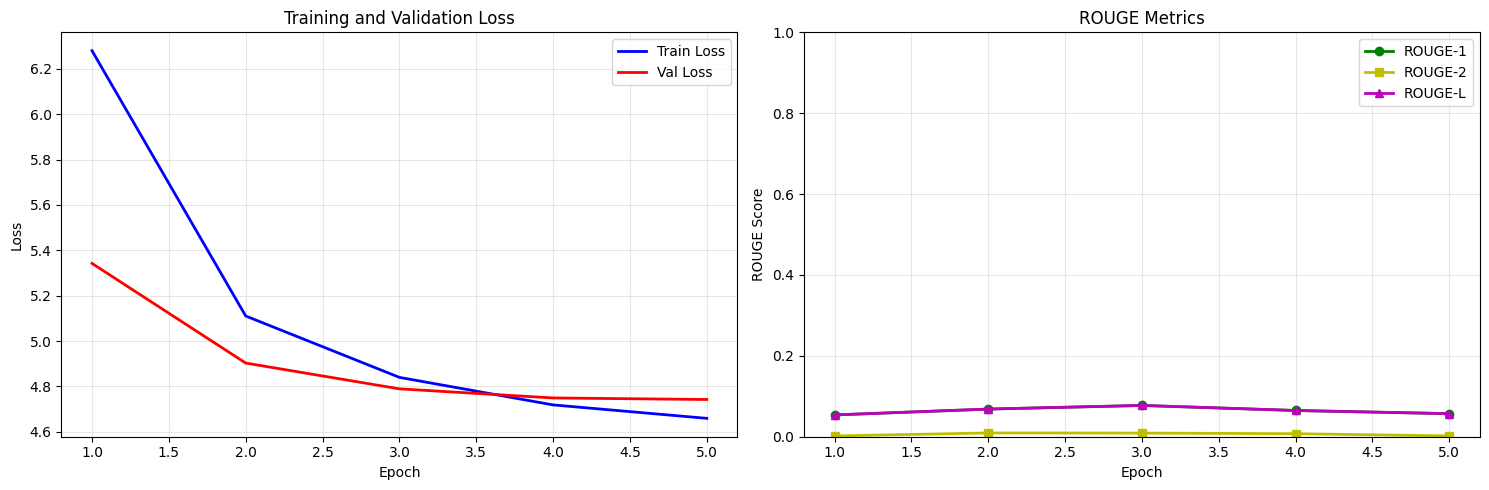


ПРИМЕРЫ ГЕНЕРАЦИИ ТЕКСТА
(контекст: первые 3/4 текста, цель: оставшаяся 1/4)

Пример 1:
  Контекст (19 слов): 'played santa claus for uncannies winners - it really sucks if u give away gifts that u'd rather keep'
  Оригинал (7 слов): '(a swanky 16gb iphone in this case)'
  Генерация (7 слов): 'it on the audio in this mor'
  ROUGE-1: 0.2857
  ROUGE-2: 0.1667
  ROUGE-L: 0.2857
------------------------------------------------------------

Пример 3:
  Контекст (17 слов): 'aw thank you!! your photo is gorgeous too, love your hair colour &amp; yes those are my'
  Оригинал (6 слов): 'drawings, glad you like them hehe!'
  Генерация (5 слов): 'favorite things, i have getting'
  ROUGE-1: 0.0000
  ROUGE-2: 0.0000
  ROUGE-L: 0.0000
------------------------------------------------------------

Пример 4:
  Контекст (17 слов): 'maybe you're watching the wrong series. i promise the red shirt thing is true in one of'
  Оригинал (6 слов): 'them! (maybe all, i'm not certain)'
  Генерация (6 слов): 'the 

In [7]:
print("\n" + "="*60)
print("ЗАПУСК ОБУЧЕНИЯ")
print("="*60)

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    tokenizer=tokenizer,
    device=device,
    dataset_processed=dataset_processed,
    epochs=5,  
    lr=0.001,
    eval_every=1
)

print("\n" + "="*60)
print("ОБУЧЕНИЕ ЗАВЕРШЕНО")
print("="*60)

Ошибки (лосс) на обучении и валидации **одновременно** уменьшаются и остаются **близкими друг к другу,** что свидетельствует об адекватной обученности LSTM и хорошем обобщении (отсутствии явного переобучения или недообучения).

Однако метрики ROUGE получаются довольно низкими и, в частности, на вышеприведённых примерах не превышают 0.2-0.3. 

На примерах выше можно увидеть, что иногда модель угадывает некоторые слова. 

Скажем, в **примере 1** видим следующее: 

- оригинал - '(a swanky 16gb iphone in this case)'
- генерация - 'it on the audio in this mor'

То есть в примере 1 модель угадала сочетание "in this".

Другой случай - **пример 4:**

- оригинал - 'them! (maybe all, i'm not certain)'
- генерация - 'the two years of the flu'

То есть в примере 4 модель угадала три буквы в начале (the).

### **3.3 Оценка модели LSTM на тестовых данных**

In [8]:
print("\n" + "="*60)
print("ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*60)

test_metrics = compute_rouge_metrics(
                              model=model,
                              dataloader=test_loader,
                              tokenizer=tokenizer,  
                              device=device,
                              model_type='lstm',
                              max_examples=200, 
                              context_ratio=0.75,
                              max_gen_len=5
                              )


ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ

Вычисление ROUGE метрик для модели LSTM
Контекст: 75%, генерация: 25%
Будет обработано примеров: 200


Оценка LSTM:   0%|          | 0/338 [00:00<?, ?it/s]


РЕЗУЛЬТАТЫ ДЛЯ МОДЕЛИ LSTM:
  Обработано примеров: 200
  ROUGE-1: 0.0488
  ROUGE-2: 0.0000
  ROUGE-L: 0.0488


Метрики ROUGE-1 и ROUGE-L - довольно низкие (0.0488), в то время как ROUGE-2 вообще менее 0.0001. 

Скорее всего, это связано с простой архитектурой нашей модели LSTM (размерности эмбединга и скрытого слоя - 128, а слой всего один) и - возможно - всё ещё недостаточно большим размером исходного датасета. Метрики можно отчасти улучшить, взяв более сложную модель (хотя бы увеличить число слоёв), но это приведёт к повышенным требованиям к устройствам пользователей + обучение модели будет длится часами. Могу предположить, что в случае действительно коротких сообщений (типа "я еду") модель может генерировать более удачные продолжения (например, "домой"). 

***Примечание:*** для оценки взял только 200 примеров из тестовой выборки, поскольку в противном случае ячейка выполняется очень, очень долго. При этом метрики, как я понимаю, получатся почти такими же. 

### **3.4 Сохранение модели LSTM**

In [9]:
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': tokenizer.vocab_size,
    'history': history
}, 'models/best_LSTM_model_5epochs.pth')

print("\nМодель сохранена как 'models/best_LSTM_model_5epochs.pth'")


Модель сохранена как 'models/best_LSTM_model_5epochs.pth'


**ВЫВОДЫ ПО РАЗДЕЛУ 3:**
- создана и обучена модель LSTM
- метрики модели LSTM на тестовых данных: ROUGE-1 = 0.0488, ROUGE-2 = 0.0000, ROUGE-L = 0.0488
- низкое качество модели LSTM может быть связано с её простой архитектурой (один слой и низкие размерности эмбединнга и скрытого состояния)

## **4. Подбор параметров и оценка трансформера DISTILGPT2**

### **4.1 Загрузка предобученного DISTILGPT2**

In [10]:
print("\n" + "="*60)
print("ЗАГРУЗКА МОДЕЛИ DISTILGPT2")
print("="*60)

gpt2_tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
gpt2_model = AutoModelForCausalLM.from_pretrained("distilgpt2").to(device)

if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

print(f"Модель загружена. Параметров: {sum(p.numel() for p in gpt2_model.parameters()):,}")
print(f"Размер словаря: {len(gpt2_tokenizer)}")


ЗАГРУЗКА МОДЕЛИ DISTILGPT2
Модель загружена. Параметров: 81,912,576
Размер словаря: 50257


### **4.2 Подбор параметров генерации DISTILGPT2**

Подберём оптимальные параметры генерации текстов (temperature, top_k, top_p) для DISTILGPT2 на валидационных данных, ориетируясь на метрику ROUGE-1 как наиболее понятную:

In [11]:
# подбираем параметры на валидационных данных
best_params = find_best_generation_params(gpt2_model, val_loader, tokenizer, device)


ПОДБОР ПАРАМЕТРОВ ГЕНЕРАЦИИ
Собрано 500 тестовых примеров из валидационной выборки

Оценка различных комбинаций параметров...


temp=0.6: 100%|██████████| 500/500 [00:23<00:00, 21.02it/s]


  ROUGE-1: 0.0004


temp=0.7: 100%|██████████| 500/500 [00:24<00:00, 20.80it/s]


  ROUGE-1: 0.0004


temp=0.7: 100%|██████████| 500/500 [00:23<00:00, 20.90it/s]


  ROUGE-1: 0.0005


temp=0.8: 100%|██████████| 500/500 [00:23<00:00, 20.88it/s]


  ROUGE-1: 0.0004


temp=0.8: 100%|██████████| 500/500 [00:23<00:00, 21.34it/s]


  ROUGE-1: 0.0000


temp=0.9: 100%|██████████| 500/500 [00:23<00:00, 21.45it/s]

  ROUGE-1: 0.0013

ЛУЧШИЕ ПАРАМЕТРЫ (ROUGE-1: 0.0013):
  temperature = 0.9
  top_k = 70
  top_p = 0.98


***Примечание:*** подбор параметров осуществляли не на всей валидации, а только на 500 примерах, поскольку это не обучение, а лишь подбор малого числа параметров генерации текста.

### **4.2 Оценка DISTILGPT2**

Оценим качество DISTILGPT2 с подобранными оптимальными параметрами на тестовой выборке:

In [12]:
print("\n" + "="*60)
print("ОЦЕНКА МОДЕЛИ DISTILGPT2 С ОПТИМАЛЬНЫМИ ПАРАМЕТРАМИ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*60)

gpt2_metrics = compute_rouge_metrics(
    model=gpt2_model,
    dataloader=test_loader,
    tokenizer=tokenizer,  
    device=device,
    gpt2_tokenizer=gpt2_tokenizer,
    generation_params=best_params,  # параметры для GPT-2
    model_type='gpt2',
    max_examples=200,  
    context_ratio=0.75,
    max_gen_len=10
)


ОЦЕНКА МОДЕЛИ DISTILGPT2 С ОПТИМАЛЬНЫМИ ПАРАМЕТРАМИ НА ТЕСТОВОЙ ВЫБОРКЕ

Вычисление ROUGE метрик для модели GPT2
Контекст: 75%, генерация: 25%
Будет обработано примеров: 200


Оценка GPT2:   0%|          | 0/338 [00:02<?, ?it/s]


РЕЗУЛЬТАТЫ ДЛЯ МОДЕЛИ GPT2:
  Обработано примеров: 200
  ROUGE-1: 0.0667
  ROUGE-2: 0.0100
  ROUGE-L: 0.0667


Судя по метрикам ROUGE, трансформер DISTILGPT2 справляется с автозаполнением текстов лучше, чем LSTM у которой ROUGE-1 = 0.0488, ROUGE-2 = 0.0000 и ROUGE-L = 0.0488. По-видимому, это связано с более сложной архитектурой DISTILGPT2 по сравнению с LSTM. Однако метрики всё равно довольно низкие и примеры генерации текстов это наглядно иллюстрируют. Поскольку DISTILGPT2 сложнее и - как и LSTM - обучалась на всём наборе твитов, то могу предположить, что проблема заключается в размере датасета (видимо, 1,6 миллиона твитов - всё-таки мало). И аналогично LSTM в случае DISTILGPT2 можно предположить, что DISTILGPT2 мог бы показывать более хорошие результаты при дополнении коротких текстов типа "я ложусь".

### **4.3 Сохранение модели DISTILGPT2**

In [13]:
torch.save({
    'model_state_dict': gpt2_model.state_dict(),  
    'vocab_size': len(gpt2_tokenizer),             
    'best_params': best_params, # лучшие параметры генерации
    'model_config': gpt2_model.config            
}, 'models/best_gpt2_model.pth')

print("Модель GPT-2 сохранена как 'models/best_gpt2_model.pth'")

Модель GPT-2 сохранена как 'models/best_gpt2_model.pth'


### **4.4 Примеры предсказаний DISTILGPT2 с оптимальными параметрами**

In [14]:
# показываем примеры с лучшими параметрами
show_gpt2_predictions(gpt2_model, gpt2_tokenizer, device, dataset_processed=dataset_processed, params=best_params)


ПРИМЕРЫ ПРЕДСКАЗАНИЙ МОДЕЛИ DISTILGPT2

Пример 1:
  Контекст: 'screen cracked n doesn't recognize wen she'
  Оригинал: 'presses buttons now'
  Генерация: ' knows he's'
  ROUGE-1: 0.0000
  ROUGE-2: 0.0000
  ROUGE-L: 0.0000
------------------------------------------------------------

Пример 2:
  Контекст: 'i was teasin' last night and totally understand your're human with only 2 hands! are'
  Оригинал: 'folks really hasslin' ya over this?'
  Генерация: ' you just doing this now,'
  ROUGE-1: 0.1818
  ROUGE-2: 0.0000
  ROUGE-L: 0.1818
------------------------------------------------------------

Пример 4:
  Контекст: 'cannot find my'
  Оригинал: 'microphone cable'
  Генерация: ' current state'
  ROUGE-1: 0.0000
  ROUGE-2: 0.0000
  ROUGE-L: 0.0000
------------------------------------------------------------

Пример 5:
  Контекст: 'i rather like to'
  Оригинал: 'wear clothes.'
  Генерация: ' buy the'
  ROUGE-1: 0.0000
  ROUGE-2: 0.0000
  ROUGE-L: 0.0000
------------------------------------

Как и в случае LSTM, трансформер DISTILGPT2 не очень хорошо справляется с генерацией текста. 

В примере 2 видим следующее:
- оригинал: 'folks really hasslin' ya over this?'
- генерация: ' you just doing this now,'

В отличие от LSTM, модель DISTILGPT 2 уже угадала не просто символы, а целое слово (this) - правда, поставила его не в том месте. Тем не менее, это уже лучше.

**ВЫВОДЫ ПО РАЗДЕЛУ 4:**
- подобраны параметры генерации (temperature, top_k, top_p) для предобученного трансформера DISTILGPT 2
- метрики модели DISTILGPT 2 на тестовых данных: ROUGE-1 = 0.0667, ROUGE-2 = 0.0100, ROUGE-L =  0.0667
- низкое качество модели DISTILGPT 2 может быть связано с ограниченным объёмом датасета (возможно, 1,6 миллиона твитов слишком мало)

## **5. Итоговое сравнение LSTM и DISTILGPT 2**

### **5.1 Сравнение LSTM и DISTILGPT 2 на примерах**

Посмотрим, как модели LSTM и DISTILGPT 2 справляются с одними и теми же примерами:

In [15]:
# запускаем сравнение
compare_model_predictions(
    lstm_model=model,
    gpt2_model=gpt2_model,
    lstm_tokenizer=tokenizer,
    gpt2_tokenizer=gpt2_tokenizer,
    device=device,
    dataset_processed=dataset_processed,
    num_examples=5,
    gpt2_params=best_params
)


СРАВНЕНИЕ ПРЕДСКАЗАНИЙ МОДЕЛЕЙ LSTM И DISTILGPT2

Пример 1:
  Контекст: 'holy crap the sun is hot i'm actually stayin inside because i don't wanna turn anymore red.. redder?'
  Оригинал: 'redish.. turn into a lobster! ugh..'

  LSTM генерация:     'the storm are playing in'
    ROUGE-1: 0.0000
    ROUGE-2: 0.0000
    ROUGE-L: 0.0000

  DistilGPT2 генерация: ' i just got on a white'
    ROUGE-1: 0.1667
    ROUGE-2: 0.0000
    ROUGE-L: 0.1667
--------------------------------------------------------------------------------

Пример 2:
  Контекст: 'some one talk'
  Оригинал: 'to me'

  LSTM генерация:     'to my blog. dammit'
    ROUGE-1: 0.3333
    ROUGE-2: 0.0000
    ROUGE-L: 0.3333

  DistilGPT2 генерация: ', and'
    ROUGE-1: 0.0000
    ROUGE-2: 0.0000
    ROUGE-L: 0.0000
--------------------------------------------------------------------------------

Пример 3:
  Контекст: 'i want penne. i guess i have to live'
  Оригинал: 'off of tuna.'

  LSTM генерация:     'drinking cake...'
    R

Судя по всему, обе модели показывают плюс-минус похожие результаты. В примере 1 модель DistilGPT2 угадала несколько букв, а в примере 2 модель LSTM угадала слово и одну букву, дописав лишний текст. В трёх остальных примерах обе модели не справились с задачей в принципе.

### **5.2 Сравнение LSTM и DISTILGPT 2 по метрикам ROUGE**

Посмотрим на таблицу с метриками ROUGE для обеих моделей:

In [16]:
print("\n" + "="*60)
print("СВОДНАЯ ТАБЛИЦА МЕТРИК")
print("="*60)

print(f"\nМетрики на тестовой выборке ({test_metrics['num_samples']} примеров):")
print(f"{'Модель':<20} {'ROUGE-1':<12} {'ROUGE-2':<12} {'ROUGE-L':<12}")
print("-"*60)
print(f"{'LSTM':<20} {test_metrics['rouge1']:.4f}      {test_metrics['rouge2']:.4f}      {test_metrics['rougeL']:.4f}")
print(f"{'DistilGPT2':<20} {gpt2_metrics['rouge1']:.4f}      {gpt2_metrics['rouge2']:.4f}      {gpt2_metrics['rougeL']:.4f}")

# вычисляем улучшение
improvement_r1 = ((gpt2_metrics['rouge1'] - test_metrics['rouge1']) / test_metrics['rouge1']) * 100 if test_metrics['rouge1'] > 0 else 0
improvement_r2 = ((gpt2_metrics['rouge2'] - test_metrics['rouge2']) / test_metrics['rouge2']) * 100 if test_metrics['rouge2'] > 0 else 0
improvement_rL = ((gpt2_metrics['rougeL'] - test_metrics['rougeL']) / test_metrics['rougeL']) * 100 if test_metrics['rougeL'] > 0 else 0

print("\n" + "="*60)
print("УЛУЧШЕНИЕ DISTILGPT2 ОТНОСИТЕЛЬНО LSTM:")
print("="*60)
print(f"ROUGE-1: +{improvement_r1:.1f}%")
print(f"ROUGE-2: +{improvement_r2:.1f}%")
print(f"ROUGE-L: +{improvement_rL:.1f}%")
print("="*60)


СВОДНАЯ ТАБЛИЦА МЕТРИК

Метрики на тестовой выборке (200 примеров):
Модель               ROUGE-1      ROUGE-2      ROUGE-L     
------------------------------------------------------------
LSTM                 0.0488      0.0000      0.0488
DistilGPT2           0.0667      0.0100      0.0667

УЛУЧШЕНИЕ DISTILGPT2 ОТНОСИТЕЛЬНО LSTM:
ROUGE-1: +36.7%
ROUGE-2: +0.0%
ROUGE-L: +36.7%


Судя по метрикам ROUGE, модель DISTILGPT2 лучше справляется с задачей автозаполнения текста, но абсолютные значения метрик довольно низкие (менее 0.1). 

Вероятно, требуется какой-то другой подход к решению поставленной задачи.



**ВЫВОДЫ ПО РАЗДЕЛУ 5:**
- модели LSTM и DISTILGPT 2 почти одинаковы с точки зрения метрик ROUGE
- незначительное превосходство DISTILGPT 2 над LSTM, скорее всего, обусловлено более сложной архитектурой DISTILGPT 2
- возможно, что обе модели показывали бы более хорошие результаты при автодополнении коротких текстов типа "я люблю"

## **6. ИТОГОВЫЕ ВЫВОДЫ**

Согласно ТЗ заказчиков, создана и обучена модель LSTM и подобраны оптимальные параметры генерации трансформера DISTILGPT 2 для автодополнения текстов. Было учтено указание по "нетребовательности" модели к ресурсам (оперативной памяти) устройств пользователей. Итоговые метрики ROUGE (ROUGE-1, ROUGE-2 и ROUGE-L) на тестовых выборках для обеих моделей не превышают 0.07, что недостаточно для адекватного дополнения текстов. 

Можно предположить, что предоставленный датасет недостачно большой (видимо, нужно более 1,6 миллиона твитов) для текущей задачи, поскольку даже предобученный DISTILGPT 2 с более сложной архитектурой не справляется с задачей. Альтернативным выходом является упрощение самой задачи - то есть сделать приложение, которое дополняет совсем короткие сообщения типа "как твои" (должно генерироваться "дела"), а не генерирует 1/4 оставшейся части текста (что очень сложно в случае длинных предложений).